In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from tqdm.notebook import tqdm
from torch.utils.data.sampler import WeightedRandomSampler

# DataSet Creation

In [ ]:
df = pd.read_csv('/kaggle/input/celeb-df-v2/List_of_testing_videos.txt',delimiter=' ')
df.shape

(517, 2)

In [ ]:

def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []

    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)

    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]

    real_videos = real_videos[:890]
    fake_videos = fake_videos[:890]

    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")

    splits_dict = {split: [] for split in ['train', 'val', 'test']}

    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)

        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)

    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)

    return splits_dict, class_counts

In [ ]:

class VideoDatasetSplit(Dataset):
    def __init__(self, base_path, split_path, split='train', sequence_length=15, transform=None):
        self.base_path = Path(base_path)
        self.sequence_length = sequence_length
        self.transform = transform

        with open(os.path.join(split_path, 'splits.json'), 'r') as f:
            data = json.load(f)
            self.videos = data['splits'][split]
            self.class_counts = data['class_counts']
        self.face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')


    def get_sampler(self):
        weights = []
        max_samples = max(self.class_counts.values())

        for video_path in self.videos:
            is_fake = 'synthesis' in video_path
            count = self.class_counts['fake'] if is_fake else self.class_counts['real']
            weight = max_samples / count
            weights.append(weight)

        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = 1 if 'synthesis' in video_path else 0  # 1 for fake, 0 for real

        frames = self.load_video(os.path.join(self.base_path, video_path))
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])

        return frames, label

    def __len__(self):
        return len(self.videos)

    def load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # print("TOTAL FRAMES: ",total_frames)
        indices = np.linspace(0, total_frames-1, self.sequence_length, dtype=int)

        for frame_idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                face_frame = self.detect_face(frame)
                frames.append(face_frame)
            else:
                frames.append(np.zeros(frames[-1].shape, dtype=np.uint8))


        cap.release()
        return np.stack(frames)
    def detect_face(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = frame[y:y+h, x:x+w]
            return cv2.resize(face, (224, 224))
        else:
            return cv2.resize(frame, (224, 224))
def create_dataloaders(base_path, output_path,dim, batch_size=4, sequence_length=10):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((dim, dim)),
        transforms.RandomAdjustSharpness(sharpness_factor=1.8, p=0.5),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    splits_dict, class_counts = create_dataset_splits(base_path, output_path)

    train_dataset = VideoDatasetSplit(base_path, output_path, 'train', sequence_length, transform)
    val_dataset = VideoDatasetSplit(base_path, output_path, 'val', sequence_length, transform)
    test_dataset = VideoDatasetSplit(base_path, output_path, 'test', sequence_length, transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.get_sampler(),
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, class_counts

In [ ]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders('/kaggle/input/celeb-df-v2','/kaggle/working/',dim=224,batch_size=4,sequence_length=15)

Real videos: 890, Fake videos: 890


## Visualizing

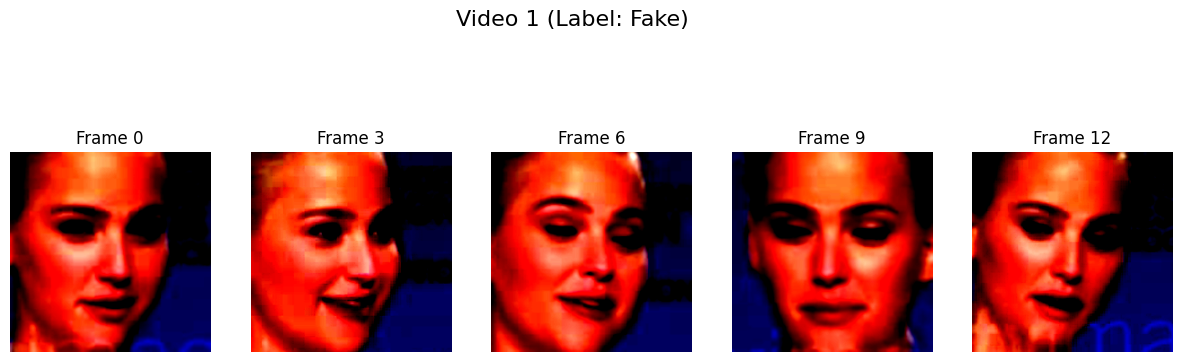

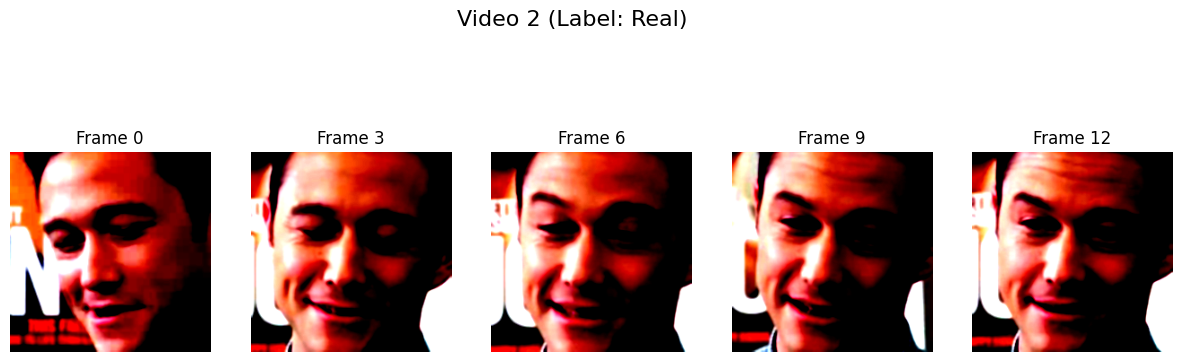

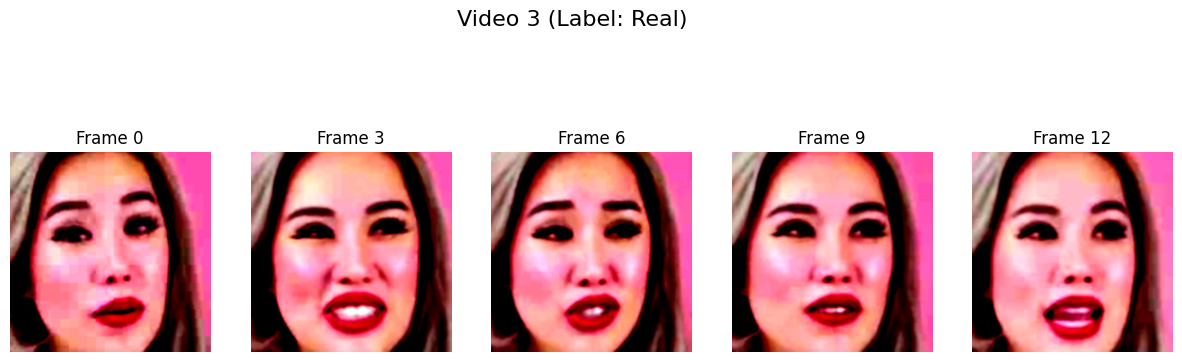

In [ ]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=2, num_frames=5):
    batch = next(iter(data_loader))
    videos, labels = batch
    videos = videos[:num_videos]
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        video = video.permute(0, 2, 3, 1).numpy()

        # Plot frames
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)

        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")

        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=5)

# Model Creation

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import wandb
import torch.nn.functional as F

class DynamicVideoClassifier(nn.Module):
    def __init__(self,  hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()

        self.valid_backbones ="mobilenet_v2"
        self.feature_size = self.backbone.classifier[1].in_features
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        self.backbone = getattr(models, backbone)(pretrained=True)
        avg_size = 1

        self.avg_pool = nn.AdaptiveAvgPool2d((avg_size, avg_size))
        # LSTM for temporal features
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        x = self.backbone(x)
        x = self.avg_pool(x)
        x = x.view(batch_size, seq_len, -1)
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_features = torch.sum(attention_weights * lstm_out, dim=1)
        # Classification
        output = self.classifier(attended_features)
        return output.squeeze()

In [ ]:
class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=10,
        device='cuda',
        use_wandb=False
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.metrics = []

        pos_weight = self._calculate_pos_weight()
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )

        if use_wandb:
            self._init_wandb()

    def _calculate_pos_weight(self):
        pos_weight_path = "/kaggle/input/pos_weights/pytorch/default/1/pos_weight.pth"
        if os.path.exists(pos_weight_path):
            pos_weight = torch.load(pos_weight_path).to(self.device)
            print("Loaded saved pos_weight!")
            return pos_weight

        count = 0
        total_pos = 0
        for i, (_, label) in enumerate(self.train_loader.dataset):
            total_pos += 1 if label == 1 else 0
            count += 1
            if count % 100 == 0:
                print(f"Processed {count} samples...")

        total_neg = len(self.train_loader.dataset) - total_pos
        print(f"Total positive: {total_pos}, Total negative: {total_neg}")

        if total_pos == 0:
            print("Warning: No positive samples found! Setting pos_weight to 1.0")
            pos_weight = torch.tensor([1.0]).to(self.device)
        else:
            pos_weight = torch.tensor([total_neg / total_pos]).to(self.device)

        torch.save(pos_weight, pos_weight_path)
        print("Saved pos_weight successfully!")

        return pos_weight

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": "mobilenet_v2",
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.to(self.device)
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []

        progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), desc="Training", leave=True)

        for batch_idx, (videos, labels) in progress_bar:
            videos, labels = videos.to(self.device), labels.to(self.device).float()
            self.optimizer.zero_grad()
            outputs = self.model(videos)
            loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print("Train Epoch Loss: ",metrics['loss'])
        return metrics

    def validate(self,mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader
        if mode == 'test':
            loader = self.test_loader
        progress_bar = tqdm(enumerate(loader), total=len(self.train_loader), desc="Training", leave=True)
        with torch.no_grad():
            for batch_idx, (videos, labels) in progress_bar:
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print("Validation Epoch Loss: ",metrics['loss'])
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)

        binary_preds = (predictions > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary'
        )
        auc = roc_auc_score(targets, predictions)

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()

            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                torch.save(self.model.state_dict(), 'best_model.pth')

            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }

            self._log_metrics(metrics)
        print("[Running on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)

    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        self.metrics.append(metrics)
        # Weight and Biases
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [ ]:
def train_model(train_loader, val_loader,test_loader, config=None):
    valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2'
    ]
    if config is None:
        config = {
            'backbone': valid_backbones[4],
            'hidden_size': 512,
            'num_layers': 2,
            'dropout': 0.3,
            'learning_rate': 7.278416345265247e-05,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }

    model = DynamicVideoClassifier(
        backbone=config['backbone'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.nn.DataParallel(model)
    model.to(device)
    print('set model to cuda')
    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader= test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb']
    )
    print('starting the training...')
    trainer.train()
    return model , trainer.metrics

In [ ]:
 model , metrics = train_model(train_loader, val_loader,test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


set model to cuda
Loaded saved pos_weight!
starting the training...


<ipython-input-10-c96a32cad717>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pos_weight = torch.load(pos_weight_path).to(self.device)


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.6807895326652588


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validation Epoch Loss:  0.6761381937496698
Epoch 1/10
Train - precision: 0.6586 | recall: 0.4043 | f1: 0.5010 | auc: 0.6463 | loss: 0.6808
Val - precision: 0.6172 | recall: 0.9699 | f1: 0.7544 | auc: 0.8566 | loss: 0.6761


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.6188587882579901


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Epoch Loss:  0.6110693696719497
Epoch 2/10
Train - precision: 0.7392 | recall: 0.8306 | f1: 0.7822 | auc: 0.7866 | loss: 0.6189
Val - precision: 0.7345 | recall: 0.9774 | f1: 0.8387 | auc: 0.9503 | loss: 0.6111


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.6317654155576841


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validation Epoch Loss:  0.5803549249670399
Epoch 3/10
Train - precision: 0.7458 | recall: 0.7325 | f1: 0.7391 | auc: 0.7941 | loss: 0.6318
Val - precision: 0.8231 | recall: 0.9098 | f1: 0.8643 | auc: 0.9205 | loss: 0.5804


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.6014608170550603


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validation Epoch Loss:  0.5576450491129462
Epoch 4/10
Train - precision: 0.8231 | recall: 0.7520 | f1: 0.7860 | auc: 0.8363 | loss: 0.6015
Val - precision: 0.9091 | recall: 0.8271 | f1: 0.8661 | auc: 0.9452 | loss: 0.5576


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5888084403406351


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Epoch Loss:  0.5424241561498215
Epoch 5/10
Train - precision: 0.8355 | recall: 0.8287 | f1: 0.8321 | auc: 0.8912 | loss: 0.5888
Val - precision: 0.9365 | recall: 0.8872 | f1: 0.9112 | auc: 0.9756 | loss: 0.5424


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5654409494346533


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validation Epoch Loss:  0.5538533556817183
Epoch 6/10
Train - precision: 0.8678 | recall: 0.8692 | f1: 0.8685 | auc: 0.8941 | loss: 0.5654
Val - precision: 0.9459 | recall: 0.7895 | f1: 0.8607 | auc: 0.9675 | loss: 0.5539


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5701428219102896


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Epoch Loss:  0.5393184040909382
Epoch 7/10
Train - precision: 0.8608 | recall: 0.8860 | f1: 0.8732 | auc: 0.9285 | loss: 0.5701
Val - precision: 0.9071 | recall: 0.9549 | f1: 0.9304 | auc: 0.9789 | loss: 0.5393


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5653620644066578


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Epoch Loss:  0.5395642616855565
Epoch 8/10
Train - precision: 0.8688 | recall: 0.8882 | f1: 0.8784 | auc: 0.9167 | loss: 0.5654
Val - precision: 0.9185 | recall: 0.9323 | f1: 0.9254 | auc: 0.9798 | loss: 0.5396


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5646195994355739


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validation Epoch Loss:  0.5608785437114203
Epoch 9/10
Train - precision: 0.8883 | recall: 0.9065 | f1: 0.8973 | auc: 0.9411 | loss: 0.5646
Val - precision: 0.8442 | recall: 0.9774 | f1: 0.9059 | auc: 0.9696 | loss: 0.5609


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Train Epoch Loss:  0.5537832393669165


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training:   0%|          | 0/312 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation Epoch Loss:  0.5477031198010516
Epoch 10/10
Train - precision: 0.8984 | recall: 0.9101 | f1: 0.9042 | auc: 0.9427 | loss: 0.5538
Val - precision: 0.8784 | recall: 0.9774 | f1: 0.9253 | auc: 0.9835 | loss: 0.5477
[Running on TEST SET]
--------------------------------------------------------------------------------


Training:   0%|          | 0/312 [00:00<?, ?it/s]

{'precision': 0.8227848101265823, 'recall': 0.9701492537313433, 'f1': 0.8904109589041096, 'auc': 0.9557529516596124}


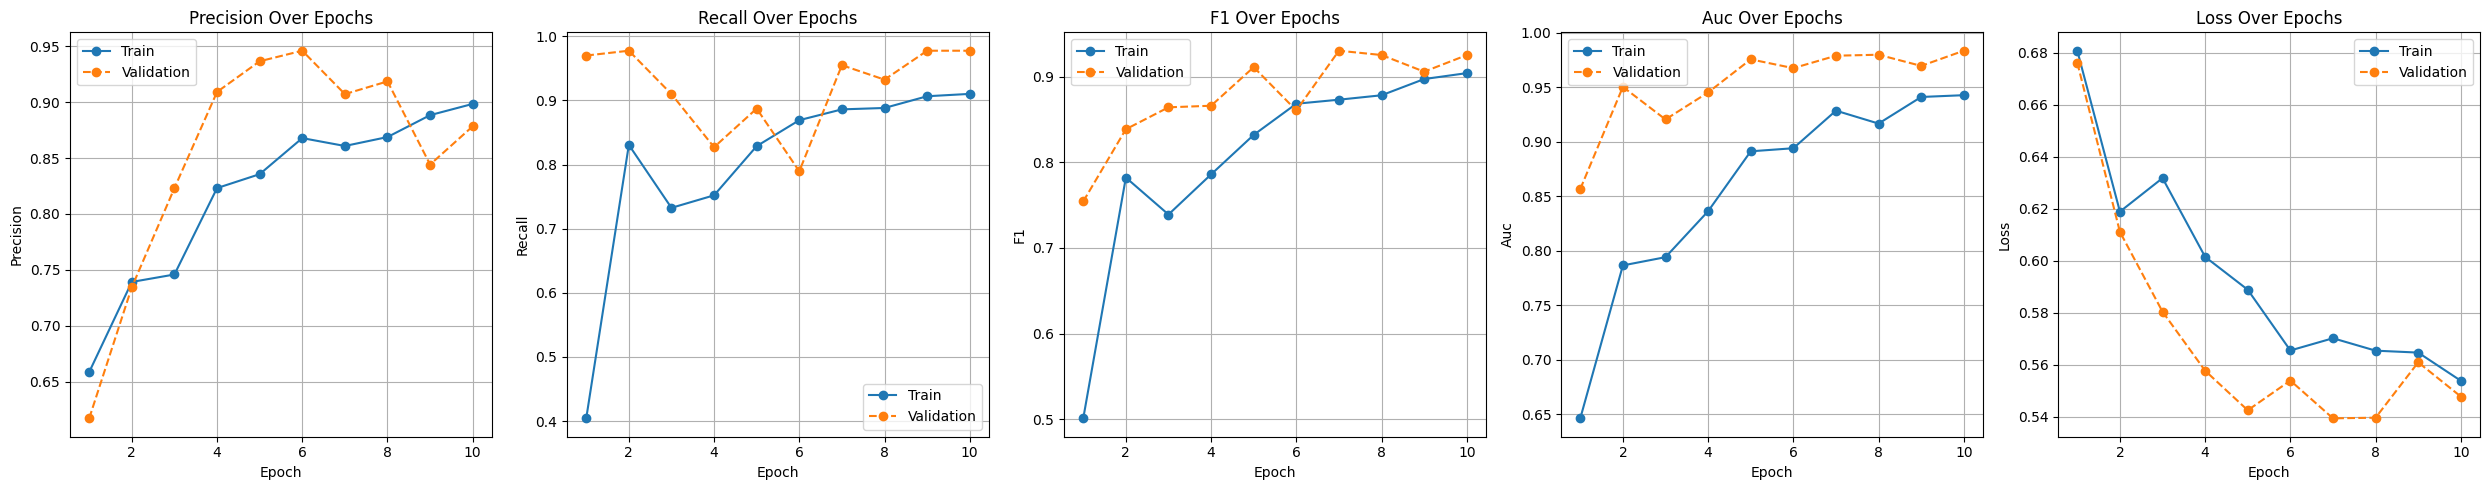

In [ ]:
# import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    # Extract epochs, training, and validation metrics
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}

    # List of metric names
    metric_names = list(train_metrics.keys())

    # Set up the plots
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    save_path="/kaggle/working/metrics_plot.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example Usage

visualize_metrics(metrics)